# Import Necessary Libraries & Data

In [37]:
# Import necessary data analysis / data visualization libraries
import pandas as pd
import numpy as np
import duckdb as db
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline


In [38]:
# Import Data: PLEASE UPDATE FILE LOCATION TO REFLECT FILE LOCATION OF YOUR ENVIRONMENT
from google.colab import drive
drive.mount('/content/drive')

products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Take Home Tests/Fetch/PRODUCTS_TAKEHOME.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Take Home Tests/Fetch/TRANSACTION_TAKEHOME.csv')
users = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Take Home Tests/Fetch/USER_TAKEHOME.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1: Exploratory Data Analysis (EDA)

## **Key Data Issues Identified**
*Only included key data issues, find queries in cells below for key + other minor data issues.*
* Transactions Table
  * 100% of product barcodes *within a receipt* have multiple records in the Transactions table.
  * 99.5% of users (unique) in Transactions table do not have any user info in the Users table.
  * 41% of product barcodes (unique) in Transactions table do not have a barcode in the Products table.
* Products Table
  * 92% of records in the Products table are missing a Category_4 value.
  * 0.5% of records in the Products table are  missing a Barcode value.
* Users Table
  * 1.4% users are either below 18 or above 100.

## **Fields Challenging To Understand (Make Assumptions)**
* All date or date time columns are across the same timezone.
* Partial (not whole numbers) product quantities  means that product barcode can be purchased by a measurement (lb., gallon etc..) vs. whole product quantities mean whole units.
* If no product sale amount or sale quantity is specified then assume it is 0.
* Created date in the Users table means date when user's Fetch account was created.
* Category 1,2,3 & 4 form a nested product hierarchy.


In [39]:
products.head(10);
transactions.head(10);
users.head(10);

In [40]:
# Get % of NaN values or empty string values in each column of each of the 3 tables
def get_missing_percentage(df):
    missing_percentage = df.isnull().sum() / len(df) * 100
    empty_string_percentage = (df == '').sum() / len(df) * 100

    combined_percentage = missing_percentage + empty_string_percentage
    combined_percentage[combined_percentage > 100] = 100  # Cap at 100%

    missing_df = pd.DataFrame({'Column': combined_percentage.index, '% Missing': combined_percentage.values})
    missing_df = missing_df.sort_values(by='% Missing', ascending=False)
    return missing_df

products_missing_percentage = get_missing_percentage(products);
transactions_missing_percentage = get_missing_percentage(transactions);
users_missing_percentage = get_missing_percentage(users);

print("Products Missing Percentage:\n", products_missing_percentage);
print("\nTransactions Missing Percentage:\n", transactions_missing_percentage);
print("\nUsers Missing Percentage:\n", users_missing_percentage);


Products Missing Percentage:
          Column  % Missing
3    CATEGORY_4  92.021898
4  MANUFACTURER  26.784160
5         BRAND  26.783923
2    CATEGORY_3   7.162895
6       BARCODE   0.476020
1    CATEGORY_2   0.168411
0    CATEGORY_1   0.013128

Transactions Missing Percentage:
            Column  % Missing
5         BARCODE     11.524
0      RECEIPT_ID      0.000
2       SCAN_DATE      0.000
1   PURCHASE_DATE      0.000
3      STORE_NAME      0.000
4         USER_ID      0.000
6  FINAL_QUANTITY      0.000
7      FINAL_SALE      0.000

Users Missing Percentage:
          Column  % Missing
4      LANGUAGE     30.508
5        GENDER      5.892
3         STATE      4.812
2    BIRTH_DATE      3.675
1  CREATED_DATE      0.000
0            ID      0.000


In [41]:
# Validate Primary Key for User table
db.sql("""
SELECT ID,
       COUNT(*) AS TOTAL_USERS
FROM users
GROUP BY 1
HAVING COUNT(*) > 1
ORDER BY 2 DESC
""").to_df()

,ID,TOTAL_USERS


In [42]:
# Validate Primary Key for Products table
db.sql("""
SELECT BARCODE,
       COUNT(*) AS TOTAL_PRODUCTS
FROM products
WHERE BARCODE IS NOT NULL
GROUP BY 1
HAVING COUNT(*) > 1
ORDER BY 2 DESC
""").to_df()

,BARCODE,TOTAL_PRODUCTS
0,60941022.0,2
1,87108538.0,2
2,3417607.0,2
3,75053055.0,2
4,20177195.0,2
...,...,...
180,20005832.0,2
181,3452905.0,2
182,3473108.0,2
183,3416808.0,2


In [43]:
# Validate Composite Key for Transactions table
db.sql("""
SELECT CONCAT(RECEIPT_ID,'-',BARCODE) AS TRANSACTION_ITEM_ID,
       COUNT(*) AS TOTAL_TRANSACTION_ITEMS
FROM transactions
GROUP BY 1
HAVING COUNT(*) > 1
ORDER BY 2 DESC
""").to_df()

,TRANSACTION_ITEM_ID,TOTAL_TRANSACTION_ITEMS
0,bedac253-2256-461b-96af-267748e6cecf-111101211...,12
1,61dc6179-7ae7-4acd-b043-8ba796bc5949-490000579...,8
2,bc304cd7-8353-4142-ac7f-f3ccec720cb3-311111998...,8
3,2acd7e8d-37df-4e51-8ee5-9a9c8c1d9711-240000483...,8
4,4ec870d2-c39f-4a40-bf8a-26a079409b20-723920163...,8
...,...,...
24790,ffd8d748-db47-40fd-aafa-84359e630cec-,2
24791,ffdd4e16-5024-4f6b-a8a2-457b07ad377f-681131169...,2
24792,ffe07f45-8538-43e6-964e-3262d59b5619-243000310...,2
24793,fff60bb7-bf93-4e6b-8055-4d7688da7ead-787422132...,2


In [44]:
# Validate if 1 transaction is associated to 1 user or not
db.sql("""
SELECT RECEIPT_ID,
       COUNT(DISTINCT USER_ID) AS TOTAL_USERS
FROM transactions
GROUP BY 1
HAVING COUNT(DISTINCT USER_ID) > 1
ORDER BY 2 DESC
""").to_df()

,RECEIPT_ID,TOTAL_USERS


In [45]:
# Validate if 1 transaction is associated to 1 store or not
db.sql("""
SELECT RECEIPT_ID,
       COUNT(DISTINCT STORE_NAME) AS TOTAL_STORES
FROM transactions
GROUP BY 1
HAVING COUNT(DISTINCT STORE_NAME) > 1
ORDER BY 2 DESC
""").to_df()

,RECEIPT_ID,TOTAL_STORES


In [46]:
# Check which stores has the higher proportion of receipts with missing products barcode
db.sql("""
WITH a AS (
SELECT STORE_NAME,
       COUNT(DISTINCT RECEIPT_ID) AS TOTAL_RECEIPTS_WITH_MISSING_PRODUCT_BARCODE
FROM transactions
WHERE BARCODE IS NULL
GROUP BY 1
)
,
b AS (
SELECT STORE_NAME,
       COUNT(DISTINCT RECEIPT_ID) AS TOTAL_RECEIPTS
FROM transactions
GROUP BY 1
)

SELECT b.*,
       COALESCE(TOTAL_RECEIPTS_WITH_MISSING_PRODUCT_BARCODE,0) AS TOTAL_RECEIPTS_WITH_MISSING_PRODUCT_BARCODE
FROM b
LEFT JOIN a ON b.STORE_NAME = a.STORE_NAME
ORDER BY 3 DESC
""").to_df()

,STORE_NAME,TOTAL_RECEIPTS,TOTAL_RECEIPTS_WITH_MISSING_PRODUCT_BARCODE
0,ALDI,1278,1132
1,CVS,579,296
2,DOLLAR TREE STORES INC,610,114
3,KROGER,725,111
4,WALGREENS,559,111
...,...,...,...
949,SOMA,1,0
950,PENNY PINCHERS,1,0
951,PHARMAMAY CABO RJO,1,0
952,MCX,1,0


In [47]:
# How many users from Transactions table are NOT in Users table?
db.sql("""
SELECT COUNT(DISTINCT a.USER_ID) AS USER_TOTAL,
       CAST(SUM(CASE WHEN b.ID IS NULL THEN 1 ELSE 0 END) AS int) AS USER_MISSING_USER_DETAILS
FROM (SELECT DISTINCT USER_ID
      FROM transactions
     ) a
LEFT JOIN (SELECT DISTINCT ID
           FROM users
          ) b ON a.USER_ID = b.ID
""").to_df()


,USER_TOTAL,USER_MISSING_USER_DETAILS
0,17694,17603


In [48]:
# How many barcodes from Transactions table are NOT in Products table?
db.sql("""
SELECT COUNT(DISTINCT a.BARCODE) AS BARCODE_TOTAL,
       CAST(SUM(CASE WHEN b.BARCODE IS NULL THEN 1 ELSE 0 END) AS int) AS BARCODE_MISSING_PRODUCT_DETAILS
FROM (SELECT DISTINCT BARCODE
      FROM transactions
     ) a
LEFT JOIN (SELECT DISTINCT BARCODE
           FROM products
          ) b ON a.BARCODE = b.BARCODE
""").to_df()

,BARCODE_TOTAL,BARCODE_MISSING_PRODUCT_DETAILS
0,11027,4466


In [49]:
# Check if there are any data issues with the Purchase & Scan dates in the Transactions table
db.sql("""
SELECT DISTINCT RECEIPT_ID
FROM transactions
WHERE CAST(PURCHASE_DATE AS DATE) > CAST(SCAN_DATE AS DATE)
""").to_df()

,RECEIPT_ID
0,05023b3d-5f83-47a7-a17c-8e8521d0bc94
1,06ce3da3-a588-4c37-93b4-0b6d11e42704
2,0b5dcb8b-7d0a-4d58-bd7c-ace179bc3fd7
3,1815fc2f-a77e-48ad-b40f-56d97c037b6b
4,25109976-74a3-4fba-88a7-2203c922bc30
5,2a6cdb6d-3a4f-49c3-ae91-cca5c272ff32
6,430687e6-0bed-448a-8ed9-9a02327007a3
7,4a471204-c9ea-4c77-a4f9-743261588f71
8,4bcb6fec-0c13-4e47-9ee5-347d49e5cd8c
9,574656c7-3bb0-48a0-96d6-4e986c530e14


In [50]:
# Check if 1 product barcode is associated to a single brand or not
db.sql("""
SELECT BARCODE,
       COUNT(DISTINCT BRAND) AS UNIQUE_BRANDS
FROM products
WHERE BARCODE IS NOT NULL
GROUP BY 1
HAVING COUNT(DISTINCT BRAND) > 1
ORDER BY 2 DESC
""").to_df()

,BARCODE,UNIQUE_BRANDS
0,7.019830e+05,2
1,8.031017e+07,2
2,4.011122e+07,2
3,4.043100e+05,2
4,3.454503e+06,2
5,3.484708e+06,2
6,1.700033e+10,2
7,3.473009e+06,2
8,2.073306e+07,2
9,1.018158e+06,2


In [51]:
# Check if 1 product barcode is associated to a single manufacturer or not
db.sql("""
SELECT BARCODE,
       COUNT(DISTINCT MANUFACTURER) AS UNIQUE_MANUFACTURER
FROM products
WHERE BARCODE IS NOT NULL
GROUP BY 1
HAVING COUNT(DISTINCT MANUFACTURER) > 1
ORDER BY 2 DESC
""").to_df()

,BARCODE,UNIQUE_MANUFACTURER
0,40111216.0,2
1,3454503.0,2
2,3484708.0,2
3,701983.0,2
4,20733056.0,2
5,1018158.0,2
6,404310.0,2
7,80310167.0,2


In [52]:
# Understand relationship between brand and manufacturer
db.sql("""
SELECT MANUFACTURER,
       COUNT(DISTINCT BRAND) AS BRANDS
FROM products
GROUP BY 1
ORDER BY 2 DESC
""").to_df()

,MANUFACTURER,BRANDS
0,PLACEHOLDER MANUFACTURER,1224
1,GENERAL LICENSED IP MANUFACTURER,87
2,PROCTER & GAMBLE,69
3,PEPSICO,63
4,UNILEVER,56
...,...,...
4350,"DEWITT COMPANY, INC",1
4351,SHINERICH INDUSTRIAL LTD.,1
4352,LA RICURA FOODS,1
4353,VIDETTE INC,1


In [53]:
# Understand relationship between brand and manufacturer (2)
db.sql("""
SELECT BRAND,
       COUNT(DISTINCT MANUFACTURER) AS MANUFACTURERS
FROM products
GROUP BY 1
ORDER BY 2 DESC
""").to_df()

,BRAND,MANUFACTURERS
0,LE PETIT MARSEILIAIS,3
1,CHAPSTICK,2
2,TYGAZ,2
3,VEET,1
4,OLD COLONY,1
...,...,...
8118,BLOEM,1
8119,QUESOS LA RICURA,1
8120,SCRUBIT,1
8121,None,0


In [54]:
# Check if there are brands with significantly higher proportion of missing products barcode
db.sql("""
WITH a AS (
SELECT BRAND,
       SUM(CASE WHEN BARCODE IS NULL THEN 1 ELSE 0 END) AS MISSING_PRODUCT_BARCODES
FROM products
WHERE BARCODE IS NULL
GROUP BY 1
)
,
b AS (
SELECT BRAND,
       COUNT(DISTINCT BARCODE) AS TOTAL_PRODUCT_BARCODES
FROM products
GROUP BY 1
)

SELECT b.*,
       COALESCE(a.MISSING_PRODUCT_BARCODES,0) AS MISSING_PRODUCT_BARCODES
FROM b
LEFT JOIN a ON b.BRAND = a.BRAND
WHERE COALESCE(a.MISSING_PRODUCT_BARCODES,0) > 0
ORDER BY 3 DESC

""").to_df()

,BRAND,TOTAL_PRODUCT_BARCODES,MISSING_PRODUCT_BARCODES
0,COCA-COLA,1510,26.0
1,ANNIE'S HOMEGROWN GROCERY,689,24.0
2,DOVE,3834,23.0
3,BAREFOOT,336,23.0
4,ORIBE,600,21.0
...,...,...,...
764,KRAFT,131,1.0
765,ZZZQUIL,184,1.0
766,DUKE'S,74,1.0
767,GOOD THINS,15,1.0


In [55]:
# Check if there are manufacturers with significantly higher proportion of missing products barcode
db.sql("""
WITH a AS (
SELECT MANUFACTURER,
       SUM(CASE WHEN BARCODE IS NULL THEN 1 ELSE 0 END) AS MISSING_PRODUCT_BARCODES
FROM products
WHERE BARCODE IS NULL
GROUP BY 1
)
,
b AS (
SELECT MANUFACTURER,
       COUNT(DISTINCT BARCODE) AS TOTAL_PRODUCT_BARCODES
FROM products
GROUP BY 1
)

SELECT b.*,
       COALESCE(a.MISSING_PRODUCT_BARCODES,0) AS MISSING_PRODUCT_BARCODES
FROM b
LEFT JOIN a ON b.MANUFACTURER = a.MANUFACTURER
WHERE COALESCE(a.MISSING_PRODUCT_BARCODES,0) > 0
ORDER BY 3 DESC
""").to_df()

,MANUFACTURER,TOTAL_PRODUCT_BARCODES,MISSING_PRODUCT_BARCODES
0,COTY,407,269.0
1,PROCTER & GAMBLE,20797,268.0
2,GENERAL MILLS,6125,245.0
3,PEPSICO,14258,210.0
4,UNILEVER,16655,209.0
...,...,...,...
121,T. MARZETTI COMPANY,140,3.0
122,TOOTSIE ROLL,1952,2.0
123,SONIC,5,2.0
124,LIFESCAN,89,2.0


In [56]:
# Check if there are category_1 with significantly higher proportion of missing products barcode
db.sql("""
WITH a AS (
SELECT CATEGORY_1,
       SUM(CASE WHEN BARCODE IS NULL THEN 1 ELSE 0 END) AS MISSING_PRODUCT_BARCODES
FROM products
WHERE BARCODE IS NULL
GROUP BY 1
)
,
b AS (
SELECT CATEGORY_1,
       COUNT(DISTINCT BARCODE) AS TOTAL_PRODUCT_BARCODES
FROM products
GROUP BY 1
)

SELECT b.*,
       COALESCE(a.MISSING_PRODUCT_BARCODES,0) AS MISSING_PRODUCT_BARCODES
FROM b
LEFT JOIN a ON b.CATEGORY_1 = a.CATEGORY_1
WHERE COALESCE(a.MISSING_PRODUCT_BARCODES,0) > 0
ORDER BY 3 DESC
""").to_df()

,CATEGORY_1,TOTAL_PRODUCT_BARCODES,MISSING_PRODUCT_BARCODES
0,Health & Wellness,510382,2306.0
1,Snacks,323018,1622.0
2,Restaurant,35,34.0
3,Alcohol,475,28.0
4,Beverages,3977,12.0
5,Dairy,592,10.0
6,Apparel & Accessories,840,6.0
7,Pantry,867,4.0
8,Deli & Bakery,66,3.0


In [57]:
# Check if there are category_2 with significantly higher proportion of missing products barcode
db.sql("""
WITH a AS (
SELECT CATEGORY_2,
       SUM(CASE WHEN BARCODE IS NULL THEN 1 ELSE 0 END) AS MISSING_PRODUCT_BARCODES
FROM products
WHERE BARCODE IS NULL
GROUP BY 1
)
,
b AS (
SELECT CATEGORY_2,
       COUNT(DISTINCT BARCODE) AS TOTAL_PRODUCT_BARCODES
FROM products
GROUP BY 1
)

SELECT b.*,
       COALESCE(a.MISSING_PRODUCT_BARCODES,0) AS MISSING_PRODUCT_BARCODES
FROM b
LEFT JOIN a ON b.CATEGORY_2 = a.CATEGORY_2
WHERE COALESCE(a.MISSING_PRODUCT_BARCODES,0) > 0
ORDER BY 3 DESC
""").to_df()

,CATEGORY_2,TOTAL_PRODUCT_BARCODES,MISSING_PRODUCT_BARCODES
0,Skin Care,62183,401.0
1,Medicines & Treatments,98734,384.0
2,Bath & Body,81131,338.0
3,Hair Care,111167,313.0
4,Candy,120622,265.0
5,Snack Bars,18343,155.0
6,Chips,23587,140.0
7,Crackers,11329,116.0
8,Hair Removal,13486,112.0
9,Dips & Salsa,16170,97.0


In [58]:
# Check if there are category_3 with significantly higher proportion of missing products barcode
db.sql("""
WITH a AS (
SELECT CATEGORY_3,
       SUM(CASE WHEN BARCODE IS NULL THEN 1 ELSE 0 END) AS MISSING_PRODUCT_BARCODES
FROM products
WHERE BARCODE IS NULL
GROUP BY 1
)
,
b AS (
SELECT CATEGORY_3,
       COUNT(DISTINCT BARCODE) AS TOTAL_PRODUCT_BARCODES
FROM products
GROUP BY 1
)

SELECT b.*,
       COALESCE(a.MISSING_PRODUCT_BARCODES,0) AS MISSING_PRODUCT_BARCODES
FROM b
LEFT JOIN a ON b.CATEGORY_3 = a.CATEGORY_3
WHERE COALESCE(a.MISSING_PRODUCT_BARCODES,0) > 0
ORDER BY 3 DESC
""").to_df()

,CATEGORY_3,TOTAL_PRODUCT_BARCODES,MISSING_PRODUCT_BARCODES
0,Chocolate Candy,47557,70.0
1,Body Wash,15004,69.0
2,Vitamins & Herbal Supplements,55632,68.0
3,Cough & Cold Medicines & Treatments,7558,64.0
4,Hand & Body Lotions,18729,64.0
...,...,...,...
193,Chestnuts,304,1.0
194,Prepared Snack Pack,61,1.0
195,Snacks & Sides,0,1.0
196,Prescription Glasses Frames,0,1.0


In [59]:
# Check if there are category_4 with significantly higher proportion of missing products barcode
db.sql("""
WITH a AS (
SELECT CATEGORY_4,
       SUM(CASE WHEN BARCODE IS NULL THEN 1 ELSE 0 END) AS MISSING_PRODUCT_BARCODES
FROM products
WHERE BARCODE IS NULL
GROUP BY 1
)
,
b AS (
SELECT CATEGORY_4,
       COUNT(DISTINCT BARCODE) AS TOTAL_PRODUCT_BARCODES
FROM products
GROUP BY 1
)

SELECT b.*,
       COALESCE(a.MISSING_PRODUCT_BARCODES,0) AS MISSING_PRODUCT_BARCODES
FROM b
LEFT JOIN a ON b.CATEGORY_4 = a.CATEGORY_4
WHERE COALESCE(a.MISSING_PRODUCT_BARCODES,0) > 0
ORDER BY 3 DESC
""").to_df()

,CATEGORY_4,TOTAL_PRODUCT_BARCODES,MISSING_PRODUCT_BARCODES
0,Lip Balms,9712,25.0
1,Already Popped Popcorn,6956,18.0
2,Skin Toners,1238,16.0
3,Cold & Flu Medicines & Treatments,1405,11.0
4,Men's Shaving Gel & Cream,688,10.0
5,Sleep Aids,4968,10.0
6,Cough Drops & Lozenges,840,9.0
7,Cough & Chest Congestion Medicines & Treatments,2204,9.0
8,Heartburn & Antacids Medicines & Treatments,2747,9.0
9,Men's Razors,2833,7.0


In [60]:
# Check Category 4 column values fall under multiple higher category numbers
db.sql("""
SELECT CATEGORY_4,
       COUNT(DISTINCT CATEGORY_1) AS TOTAL_CATEGORY_1,
       COUNT(DISTINCT CATEGORY_2) AS TOTAL_CATEGORY_2,
       COUNT(DISTINCT CATEGORY_3) AS TOTAL_CATEGORY_3
FROM products
WHERE CATEGORY_4 IS NOT NULL
GROUP BY 1
ORDER BY 4 DESC
""").to_df()

,CATEGORY_4,TOTAL_CATEGORY_1,TOTAL_CATEGORY_2,TOTAL_CATEGORY_3
0,Women's Shaving Gel & Cream,1,1,1
1,Flavored Sparkling Water,1,1,1
2,Women's Razors,1,1,1
3,Immune Support,1,1,1
4,Water Pills,1,1,1
...,...,...,...,...
122,Humidifiers,1,1,1
123,Stovetop Macaroni & Cheese,1,1,1
124,Drink Sleeves,1,1,1
125,Coconut Milk,1,1,1


In [61]:
# Check Category 3 column values fall under multiple higher category numbers
db.sql("""
SELECT CATEGORY_3,
       COUNT(DISTINCT CATEGORY_1) AS TOTAL_CATEGORY_1,
       COUNT(DISTINCT CATEGORY_2) AS TOTAL_CATEGORY_2
FROM products
WHERE CATEGORY_3 IS NOT NULL
GROUP BY 1
ORDER BY 2 DESC
""").to_df()

,CATEGORY_3,TOTAL_CATEGORY_1,TOTAL_CATEGORY_2
0,Soda,2,2
1,Oral Pain Relief,1,1
2,Liquid Hand Soap,1,1
3,Confection Candy,1,1
4,Body Oil,1,1
...,...,...,...
339,Oatmeal & Hot Cereal,1,1
340,Cocktail Sauces,1,1
341,Flood & Spot Lights,1,1
342,Potatoes,1,1


In [62]:
# Check Category 2 column values fall under multiple higher category numbers
db.sql("""
SELECT CATEGORY_2,
       COUNT(DISTINCT CATEGORY_1) AS TOTAL_CATEGORY_1
FROM products
WHERE CATEGORY_2 IS NOT NULL
GROUP BY 1
ORDER BY 2 DESC
""").to_df()

,CATEGORY_2,TOTAL_CATEGORY_1
0,Sexual Health,1
1,Snack Bars,1
2,Hair Removal,1
3,First Aid,1
4,Ear Care,1
...,...,...
116,Shipping Supplies,1
117,Tea,1
118,"Vehicle Maintenance, Care & Decor",1
119,Condiments,1


In [63]:
# Check if Users table have users with improbable birth dates
db.sql("""
SELECT COUNT(DISTINCT ID) AS TOTAL_USERS,
       SUM(CASE WHEN (CURRENT_YEAR - BIRTH_YEAR) < 18 THEN 1 ELSE 0 END) AS USERS_UNDER_18,
       SUM(CASE WHEN (CURRENT_YEAR - BIRTH_YEAR) >= 100 THEN 1 ELSE 0 END) AS USERS_ABOVE_100
FROM (SELECT DISTINCT ID,
             CAST(DATE_PART('year',CAST(BIRTH_DATE AS DATE)) AS INT) AS BIRTH_YEAR,
             CAST(DATE_PART('year',CAST(CURRENT_DATE AS DATE)) AS INT) AS CURRENT_YEAR
      FROM users
     )
""").to_df()

,TOTAL_USERS,USERS_UNDER_18,USERS_ABOVE_100
0,100000,1374.0,62.0


In [64]:
# Check which users have account created date prior to user's birth date.
db.sql("""
SELECT DISTINCT ID
FROM users
WHERE CAST(BIRTH_DATE AS DATE) > CAST(CREATED_DATE AS DATE)
""").to_df()

,ID
0,5f31fc048fa1e914d38d6952


In [65]:
# Check possible values for gender column
db.sql("""
SELECT DISTINCT GENDER
FROM users
""").to_df()

,GENDER
0,transgender
1,prefer_not_to_say
2,not_listed
3,Non-Binary
4,not_specified
5,My gender isn't listed
6,female
7,None
8,male
9,non_binary


In [66]:
transactions_v2 = db.sql("""
SELECT a.*,
       b.PURCHASE_DATE,
       b.SCAN_DATE,
       b.FINAL_QUANTITY,
       b.FINAL_SALE
FROM (SELECT RECEIPT_ITEM_ID,
             RECEIPT_ID,
             BARCODE,
             USER_ID,
             STORE_NAME
      FROM (SELECT CONCAT(RECEIPT_ID,'-',BARCODE) AS RECEIPT_ITEM_ID,
                   RECEIPT_ID,
                   BARCODE,
                   USER_ID,
                   STORE_NAME,
                   ROW_NUMBER() OVER (PARTITION BY CONCAT(RECEIPT_ID,'-',BARCODE) ORDER BY CAST(PURCHASE_DATE AS DATE) DESC, CAST(SCAN_DATE AS DATE) NULLS LAST) AS RN
            FROM transactions
           )
      WHERE RN = 1
     ) a
INNER JOIN (SELECT CONCAT(RECEIPT_ID,'-',BARCODE) AS RECEIPT_ITEM_ID,
                   MIN(CAST(PURCHASE_DATE AS DATE)) AS PURCHASE_DATE,
                   MIN(CAST(SCAN_DATE AS DATE)) AS SCAN_DATE,
                   SUM(CAST(CASE WHEN FINAL_QUANTITY = 'zero' THEN '0' WHEN FINAL_QUANTITY LIKE '0.%' THEN '1' ELSE FINAL_QUANTITY END AS INT)
                      ) AS FINAL_QUANTITY,
                   SUM(CAST(CASE WHEN FINAL_SALE = ' ' THEN '0' ELSE FINAL_SALE END AS DECIMAL)
                      ) AS FINAL_SALE
            FROM transactions
            GROUP BY 1
            ) b ON a.RECEIPT_ITEM_ID = b.RECEIPT_ITEM_ID
""").to_df()

# Part 2: Analysis

## **Closed Question**
* ### **Question**: What are the top 5 brands by receipts scanned among users 21 and over?
   * #### **Assumption**:
      * Excluded any barcode, user or brand that cannot be identified aka. null values or whose details cannot be retrieved from the provided data.
   * #### **Answer**:
      * The top 5 brands by receipts scanned among users 21 and over are: Dove, Nerds Candy, Sour Patch Kids, Hershey's, & Coca-Cola

## **Open Questions**

* ### **Question**: Which is the leading brand in the Dips & Salsa category?

   * #### **Assumptions**:
      * Leading in this context is defined as the brand with highest sales.
      * Missing barcodes and missing brands are excluded as there is no reliable way to tie them to a scaned receipt's product barcode.
   * #### **Answer**:
      * The leading brands in Dips & Salsa category are: Tostitos, Good Foods, Pace, Marketside, & Fritos.

* ### **Question**: At what percent has Fetch grown year over year?
  * #### **Assumptions**:
     * Growth in this context is defined as Fetch's user base growth.
     * The Fetch account deletion or deactivation rate is negligible.
     * Year in this context is based on the user's created date's year.

  * #### **Answer**:
      * The average year over year growth in Fetch's user base is 139% from 2014 to 2024. This is an average and is highly sensitive to outliers. Please refer to the line chart below to get the yearly breakdown in Fetch's user base growth of the year over year.
     




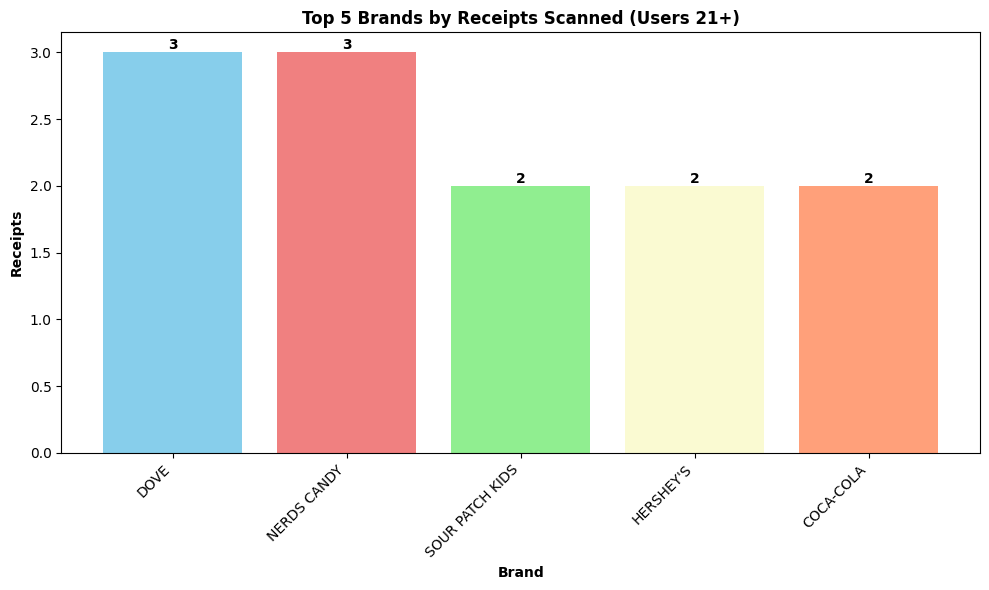

In [67]:
# What are the top 5 brands by receipts scanned among users 21 and over?

# Create dataframe to query results
top5_brands_21_plus = db.sql("""
SELECT b.BRAND,
       COUNT(DISTINCT a.RECEIPT_ID) AS TOTAL_RECEIPTS
FROM transactions_v2 a
INNER JOIN (SELECT DISTINCT BRAND,
                            BARCODE
            FROM products
            WHERE BRAND IS NOT NULL
              AND BARCODE IS NOT NULL
           ) b ON a.BARCODE = b.BARCODE
INNER JOIN (SELECT DISTINCT ID,
                            CAST(BIRTH_DATE AS DATE),
                            CAST(DATE_PART('year',CAST(CURRENT_DATE AS DATE)) AS INT) - CAST(DATE_PART('year',CAST(BIRTH_DATE AS DATE)) AS INT) AS AGE
            FROM users
            WHERE AGE >= 21
           ) c ON a.USER_ID = c.ID
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5
""").to_df();

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(top5_brands_21_plus['BRAND'], top5_brands_21_plus['TOTAL_RECEIPTS'], color=['skyblue', 'lightcoral', 'lightgreen', 'lightgoldenrodyellow', 'lightsalmon'])

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontweight='bold', color='black')

# Customize bar chart
plt.xlabel("Brand", fontweight='bold')
plt.ylabel("Receipts", fontweight='bold')
plt.title("Top 5 Brands by Receipts Scanned (Users 21+)", fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display bar chart
plt.show()

# Suppress warnings
warnings.filterwarnings('ignore')

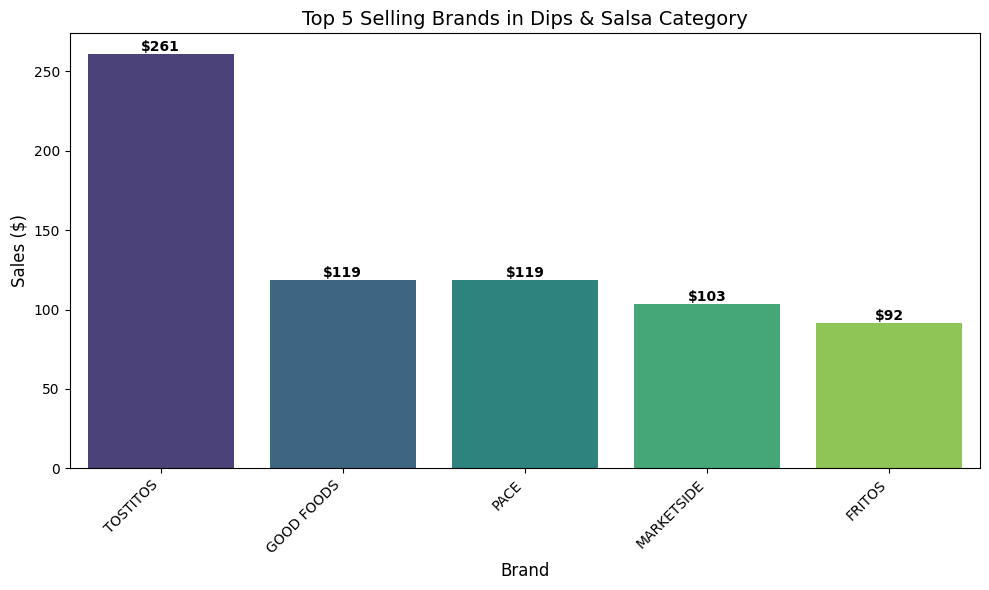

In [68]:
# Which is the leading brand in the Dips & Salsa category?

# Create dataframe to query results
top5_selling_brands = db.sql("""
SELECT b.BRAND,
       SUM(a.FINAL_SALE) AS TOTAL_SALES
FROM transactions_v2 a
INNER JOIN (SELECT DISTINCT BRAND,
                            BARCODE
            FROM products
            WHERE CATEGORY_2 = 'Dips & Salsa'
              AND BARCODE IS NOT NULL
              AND BRAND IS NOT NULL
           ) b ON a.BARCODE = b.BARCODE
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5
""").to_df();

# Create bar chart
plt.figure(figsize=(10, 6))
bars = sns.barplot(x='BRAND', y='TOTAL_SALES', data=top5_selling_brands.sort_values(by='TOTAL_SALES', ascending=False), palette='viridis')

# Add data labels
for bar in bars.patches:
    bars.annotate(f"${round(bar.get_height()):,}",
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                   ha='center', va='bottom',
                   fontsize=10, fontweight='bold')

# Customize bar chart
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Sales ($)', fontsize=12)
plt.title('Top 5 Selling Brands in Dips & Salsa Category', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display bar chart
plt.show()

# Suppress warnings
warnings.filterwarnings('ignore')

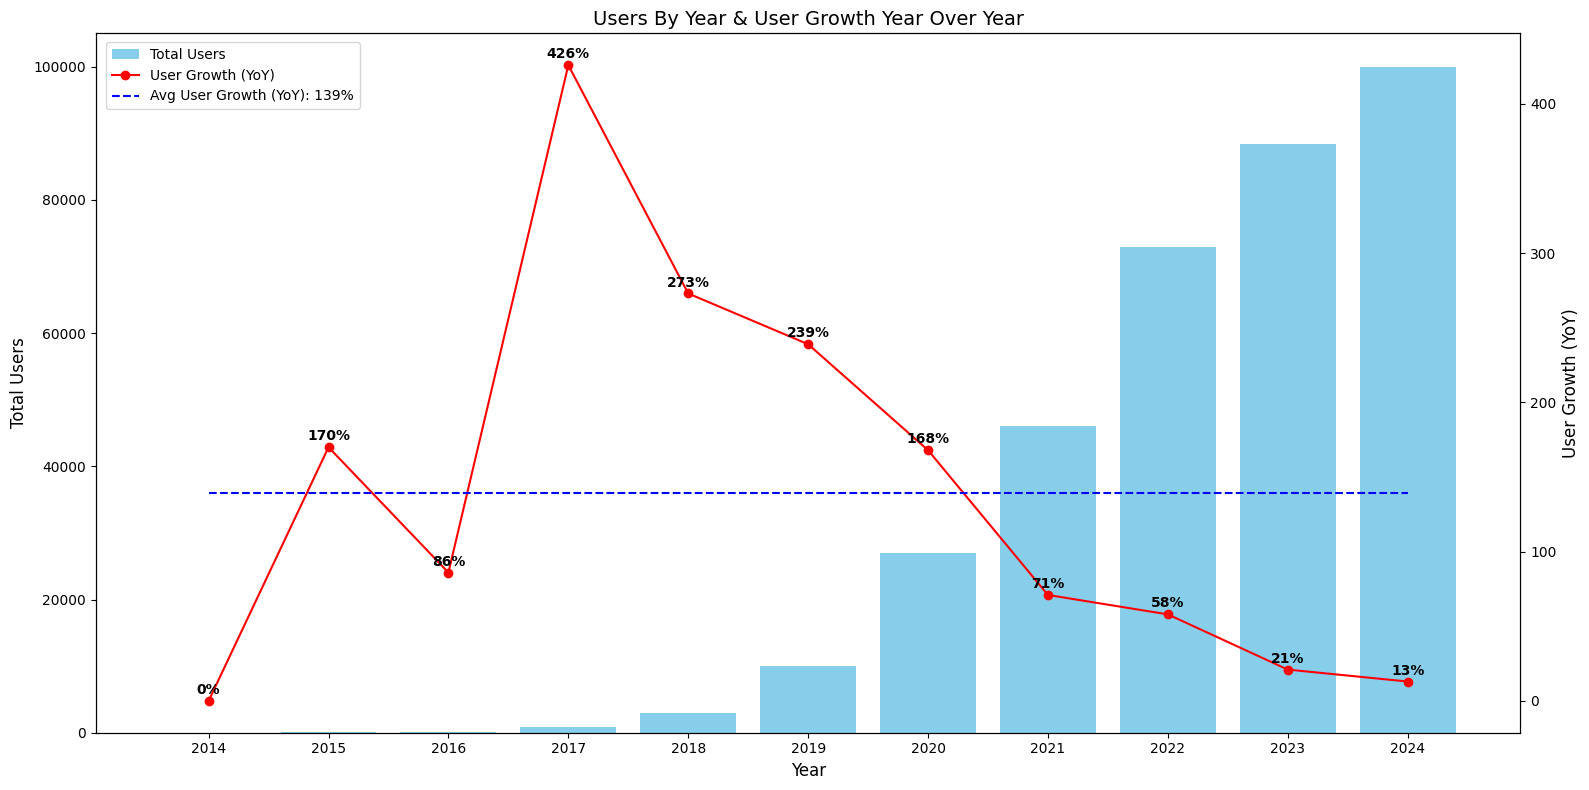

In [69]:
# At what percent has Fetch grown year over year?

# Create dataframe to query results
user_base_yoy_growth = db.sql("""
WITH a AS (
SELECT YEAR(CAST(CREATED_DATE AS DATE)) AS YEAR,
       COUNT(DISTINCT ID) AS TOTAL_USERS,
FROM users
GROUP BY 1
)
,
b AS (
SELECT DISTINCT YEAR(CAST(CREATED_DATE AS DATE)) AS YEAR
FROM users
)
,
c AS (
SELECT b.YEAR,
       CAST(SUM(a.TOTAL_USERS) AS INT) AS TOTAL_USERS
FROM a
INNER JOIN b ON a.YEAR <= b.YEAR
GROUP BY 1
)
SELECT *,
       CAST(100* (TOTAL_USERS - PREVIOUS_YEAR_USER) / PREVIOUS_YEAR_USER AS INT) AS YOY_GROWTH_PERC
FROM (SELECT *,
             COALESCE(LAG(TOTAL_USERS) OVER (ORDER BY YEAR), TOTAL_USERS) AS PREVIOUS_YEAR_USER
      FROM c
     )
ORDER BY 1
""").to_df();

# Create bar chart (Total Users)
fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.bar(user_base_yoy_growth['YEAR'], user_base_yoy_growth['TOTAL_USERS'], color='skyblue', label='Total Users')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Users', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.tick_params(axis='x', rotation=0) #ensure x axis ticks are not rotated

# Create a second y-axis for line chart
ax2 = ax1.twinx()

# Create line chart (User YoY Growth)
ax2.plot(user_base_yoy_growth['YEAR'], user_base_yoy_growth['YOY_GROWTH_PERC'], color='red', marker='o', label='User Growth (YoY)')
ax2.set_ylabel('User Growth (YoY)', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# Add data labels for line chart
for i, txt in enumerate(user_base_yoy_growth['YOY_GROWTH_PERC']):
    ax2.annotate(f'{txt}%', (user_base_yoy_growth['YEAR'][i], user_base_yoy_growth['YOY_GROWTH_PERC'][i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, fontweight='bold', color='black')

# Calculate and plot Average User YoY Growth
avg_growth = round(user_base_yoy_growth['YOY_GROWTH_PERC'].mean())
ax2.plot(user_base_yoy_growth['YEAR'], [avg_growth] * len(user_base_yoy_growth['YEAR']), color='blue', linestyle='--', label=f'Avg User Growth (YoY): {avg_growth}%')

# Customize chart
plt.title('Users By Year & User Growth Year Over Year', fontsize=14)
plt.xticks(user_base_yoy_growth['YEAR'])
fig.legend(loc='upper left' , bbox_to_anchor = (0.065,0.95))
plt.tight_layout()

# Display chart
plt.show()

# Suppress warnings
warnings.filterwarnings('ignore')

# Part 3: Conclusions

Hi,

I completed the analysis on the scanned receipts data you had requested.

After carefully looking at the data, I was able to extract some insights but I also encountered some data issues that need to be addressed. I made some assumptions to contextualize my insights in the given framework.  See details below:

* **Key Data Issues**: The user & product details in our scanned receipts do not match the information in our user list and product barcode catalog respectively.
  * For 99.5% of unique users who scanned a receipt, we have no record of them ever creating a Fetch login.
  * For 41% of unique product barcodes scanned in a receipt , we don't have product details in our catalog.

* **Insight**: Our user base has been growing consistently for 10 years (2014 to 2024).

    * I have assumed a negligible account deletion rate.
    * The rate at which our user base grows is decreasing year over year for the last 7 years. Last year our user base grew out by 13% and the year before by 21%

* **Request For Action**: In order to get more accurate insights, I will need help to answer the following:
    * Why are product barcodes in the scanned receipts not part of the product barcode catalog?
      * Are product barcodes being incorrectly captured in the receipts scanning process or is the product barcode data provided incomplete?
    * Why are users associated to the scanned receipts not part of the user masterlist?
      * Are users being incorrectly captured in the receipts scanning process or is the user data provided incomplete?
    * What are Fetch's users's account deletion dates?
      * An yearly account deletion rate would work too.
      * This would be included in the year over year user base growth calculation.

Let me know if I can further clarify anything else.

Thank you,

Rishi